# Sensitivity analysis

In [1]:
# standard imports

import numpy as np
import matplotlib.pyplot as plt

from diffusion import Domain
from diffusion.analytical import Solver, solution_1D

## Known solution

There exists an exact analytical expression (as opposed to the semi-analytical solution obtained from the solver) for the case of a single compartment, i.e. diffusion between two plates. We can use this to test the accuracy of our solver.

In [2]:
def plates(D0, d, max_l):
    """Exact analytical solution between two plates."""
    a = D0 * (np.pi/d)**2
    max_n = np.sqrt(max_l/a)  # covers range of lambdas
    return a * np.arange(0, max_n)**2  # integer steps of n

The errors of the roots of the analytical expression have a norm of:
 L-inf = 1.2086779438644713e-14
The difference between numerical and analytical roots has a norm of:
 L2 = 5.703946074418147e-11.


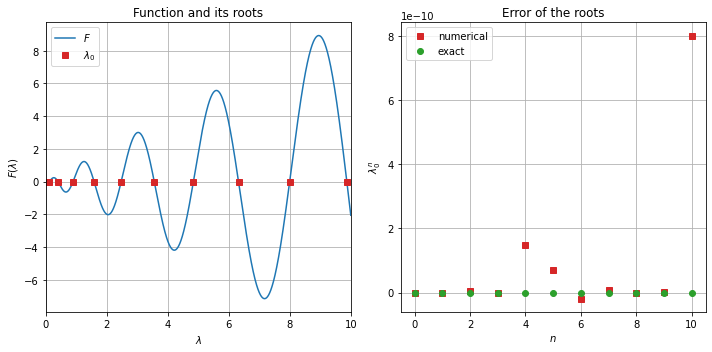

In [3]:
# problem definition
min_lambda = 0
max_lambda = 10
onecompartment = Domain([10.0], [1.0], [0, 0])
solver = Solver(onecompartment)
F = solver.eval_F

# find the roots
x0_num = solver.find_eigV(max_lambda, zero=min_lambda)
x0_ana = plates(D0=onecompartment.diffusivities[0],
                d=onecompartment.lengths[0],
                max_l=max_lambda)

# results
print('The errors of the roots of the analytical expression have a norm of:\n'
     +' L-inf = {}'.format(np.linalg.norm(F(x0_ana), np.inf)))
print('The difference between numerical and analytical roots has a norm of:\n'
     +' L2 = {}.'.format(np.linalg.norm(x0_ana-x0_num, 2)))

# make the figure
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

xF = np.linspace(min_lambda, max_lambda, 10001)
ax = axes[0]
ax.set_title('Function and its roots')
ax.plot(xF, F(xF), '-', label='$F$')
ax.plot(x0_num, F(x0_num), 's', color='tab:red', label='$\\lambda_0$')
ax.set_xlabel('$\\lambda$')
ax.set_ylabel('$F(\\lambda)$')
ax.set_xlim(min_lambda, max_lambda)
ax.legend()
ax.grid()

ax = axes[1]
ax.set_title('Error of the roots')
ax.plot(F(x0_num), 's', color='tab:red', label='numerical')
ax.plot(F(x0_ana), 'o', color='tab:green', label='exact')
ax.set_xlabel('$n$')
ax.set_ylabel('$\\lambda_0^n$')
ax.legend()
ax.grid()

# show the figure
fig.tight_layout()
plt.show()

## Eigenvalue accuracy

We now test how robust the solution is to inaccuracies in the eigenvalues. We first compute the nominal eigenvalues using the standard method. Then, a random perturbation is added to every eigenvalue and the solution is calculated. This is repeated a set number of times for each perturbation, each taken from a range of perturbations.

In [4]:
def perturb(values, perturbation, first=None, last=None):
    """Perturb an array of values."""

    # where to apply
    Neig = values.size
    if first is None:
        first = 0
    if last is None:
        last = Neig
    last = min(last, Neig)
    apply_at = np.arange(Neig)[first:last]

    # calculate
    values_p = np.array(values)  # copy
    factors = np.random.uniform(-perturbation, +perturbation, apply_at.size)
    values_p[apply_at] = np.multiply(values_p[apply_at], 1+factors)  # apply
    return values_p

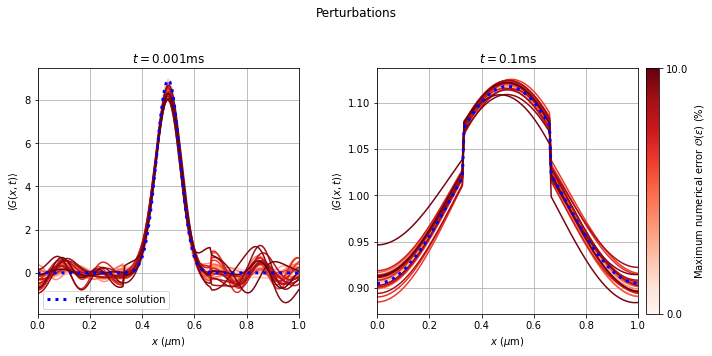

In [5]:
# problem settings
m = 3  # number of layers/compartments
d, l, k = 1, 1/m, 10  # parameters
domain = Domain(np.full(m, l), np.full(m, d),
                np.hstack((0, np.full(m-1, k), 0)))
solver = Solver(domain)

# discretization
xq = np.linspace(0, domain.total_length, m*50+1)
idx0 = xq.size//2  # in the middle
x0 = xq[idx0]

# parameters
np.random.seed(14365)  # for reproducibility
p = 0.10  # 10%
reps = 10  # repetitions
perturbations = np.linspace(0, p, 31) # odd & symmetric about 0
times = [1e-3, 1e-1] # the time points we want to look at

# plot
fig, axes = plt.subplots(1, len(times), figsize=(10, 5))
fig.suptitle('Perturbations')

# prepare color bar
cmap = plt.cm.Reds  # from faint to dark red
rgb_cycle = cmap(np.linspace(0, 1, len(perturbations)))  # scaled to [0, 1]
from mpl_toolkits.axes_grid1 import make_axes_locatable
opts = dict(position='right', size='5%', pad='3%')
cbars = [make_axes_locatable(ax).append_axes(**opts) for ax in axes]
[c.axis('off') for c in cbars[:-1]]  # disable cbar axis on all but last axis
cbar = fig.colorbar(plt.cm.ScalarMappable(cmap=cmap), cax=cbars[-1])
cbar.set_label('Maximum numerical error $\\mathcal{{O}}(\\epsilon)$ (%)')
cbar.set_ticks([0, 1])
cbar.ax.set_yticklabels(perturbations[[0,-1]]*100)

# solve the baseline solution
eigV = solver.find_eigV(max_lambda=10**5, zero=0)
eigM = solver.find_eigM(xq)

# loop
for t, ax in zip(times, axes):

    # calculate and plot sensitivity
    ax.set_prop_cycle(color=rgb_cycle)  # change sequence of colors
    for perturbation in perturbations:
        G_reps = np.zeros((reps, xq.size))
        for rep in range(reps):
            eigV_err = perturb(eigV, perturbation,
                            first=1,  # index of first modified eig
                            last=None,  # index of last modified eig
                            )
            eigM_err = solver.find_eigM(xq, eigV=eigV_err)
            G_reps[rep] = solution_1D(t, xq, idx0, 'arbitrary',
                                      lambdas=eigV_err, nus=eigM_err)
        G_err = np.mean(G_reps, axis=0)  #TODO: median?
        ax.plot(xq, G_err)

    # reference solution
    G_ref = solution_1D(t, xq, idx0, 'arbitrary',
                    lambdas=eigV, nus=eigM)
    ax.plot(xq, G_ref, color='b', ls=':', lw=3, label='reference solution')

    # pretty
    ax.grid()
    ax.set_xlabel('$x$ ($\\mu\\mathrm{{m}}$)')
    ax.set_ylabel('$\\left<G(x, t)\\right>$')
    ax.set_title('$t={}\\mathrm{{ms}}$'.format(t))
    ax.set_xlim(0, 1)
axes[0].legend()

# show the figure
fig.tight_layout(rect=[0, 0, 1, 0.95])  # protect suptitle
plt.show()

## Missing eigenmodes

Besides inaccuracies in the location of the roots/eigenvalues, it is also possible that the algorithm misses one or more roots. This leads to missing eigenmodes. Here, we study the error associated with missing a particular mode and helps assess the importance of the modes.

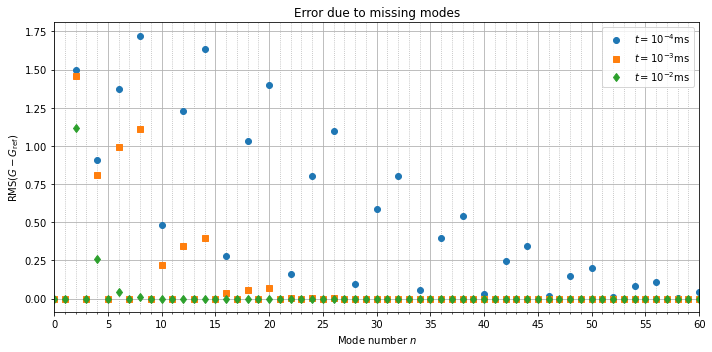

In [6]:
# parameters
times = [1e-4, 1e-3, 1e-2]
first = 1
last = 60

# create the figure
fig, axis = plt.subplots(1, 1, figsize=(10, 5))
axis.set_title('Error due to missing modes')

# loop over times
for t, marker in zip(times, ['o', 's', 'd']):

    G_ref = solution_1D(t, xq, idx0, 'arbitrary', lambdas=eigV, nus=eigM)

    # modify
    err_RMS = np.zeros(eigV.size)
    last = min(last, eigV.size-1)
    for i in range(first, last+1):
        eigV_err = np.delete(eigV, i)  # missing
        #eigV_err = np.insert(eigV, i, eigV[i])  # duplicate
        eigM_err = solver.find_eigM(xq, eigV=eigV_err)
        G_err = solution_1D(t, xq, idx0, 'arbitrary',
                            lambdas=eigV_err, nus=eigM_err)

        rms = lambda a: np.sqrt(np.mean(np.square(a)))  # root-mean-square
        err_RMS[i] = rms(G_err-G_ref)  # compute RMS of difference

    # plot
    axis.plot(err_RMS, marker=marker, linestyle='',
              label='$t = 10^{{{:.0f}}}\\mathrm{{ms}}$'.format(np.log10(t)))

axis.set_xlabel('Mode number $n$')
axis.set_ylabel('$\\mathrm{{RMS}}(G-G_{{\\mathrm{{ref}}}})$')
axis.legend()
# grid
axis.grid(axis='both', which='major')
axis.grid(axis='x', which='minor', ls=':')
axis.minorticks_on()
# x-axis ticks
axis.set_xlim(xmin=0, xmax=last)
from matplotlib.ticker import FixedLocator
axis.yaxis.set_minor_locator(FixedLocator([0]))  # can't seem to hide yminticks
axis.xaxis.set_major_locator(FixedLocator(np.arange(0, last+1, 5)))
axis.xaxis.set_minor_locator(FixedLocator(np.arange(0, last)))

# show the figure
fig.tight_layout()
plt.show()